### In this notebook, try to create new features and check various feature importances!

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt
import neurokit2 as nk
from biosppy.signals import  ecg
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML
from sklearn.preprocessing import OneHotEncoder
import copy
import pandas as pd
import seaborn as sns
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("train.csv")

##### Getting data sample for TSNE viz, it will take ages to run on complete data!

In [14]:
sample = train.sample(frac =.01)

In [49]:
sample.event.value_counts()

A    28402
C    16681
D     2302
B     1289
Name: event, dtype: int64

In [16]:

Y = sample['event']
X = sample.drop([ 'event'], axis=1 )
X_encoded = copy.deepcopy(X)


In [17]:
 X.shape

(48674, 27)

In [18]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(X['experiment'])



LabelEncoder()

##### Encoding categorical data for to apply on TSNE api

In [19]:
print(le.classes_)
X_encoded['experiment'] = le.transform(X['experiment'])

['CA' 'DA' 'SS']


## Applying TSNE for data visualization

In [23]:
import numpy as np
from sklearn.manifold import TSNE 
X_embedded = TSNE(n_components=2,  
                  init='random', perplexity=30, verbose=300).fit_transform(X_encoded)
X_embedded.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 48674 samples in 0.002s...
[t-SNE] Computed neighbors for 48674 samples in 34.588s...
[t-SNE] Computed conditional probabilities for sample 1000 / 48674
[t-SNE] Computed conditional probabilities for sample 2000 / 48674
[t-SNE] Computed conditional probabilities for sample 3000 / 48674
[t-SNE] Computed conditional probabilities for sample 4000 / 48674
[t-SNE] Computed conditional probabilities for sample 5000 / 48674
[t-SNE] Computed conditional probabilities for sample 6000 / 48674
[t-SNE] Computed conditional probabilities for sample 7000 / 48674
[t-SNE] Computed conditional probabilities for sample 8000 / 48674
[t-SNE] Computed conditional probabilities for sample 9000 / 48674
[t-SNE] Computed conditional probabilities for sample 10000 / 48674
[t-SNE] Computed conditional probabilities for sample 11000 / 48674
[t-SNE] Computed conditional probabilities for sample 12000 / 48674
[t-SNE] Computed conditional probabilities for sa

(48674, 2)

In [55]:
tsne_df = pd.DataFrame(X_embedded, columns = ["tsne_comp_1", "tsne_comp_2"])
tsne_df['label'] = Y.values

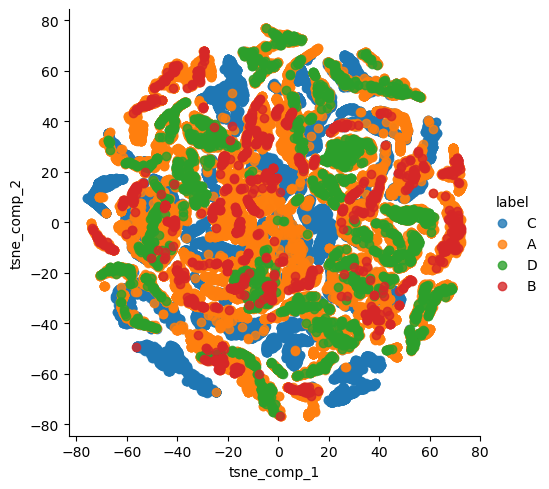

In [57]:
 
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x ='tsne_comp_1', y ='tsne_comp_2',
          fit_reg = False, hue = 'label',
          data = tsne_df)
 
# Show the p

### *Its clear its next to impossible to separate these classes easily*

In [59]:
# joblib.dump(tsne_df, "tsne_df")

['tsne_df']

## Checking feature importance!

In [61]:
Y = train['event']
X = train.drop('event',axis=1)
features = X.columns
print(features)

Index(['crew', 'experiment', 'time', 'seat', 'eeg_fp1', 'eeg_f7', 'eeg_f8',
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',
       'eeg_c3', 'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr'],
      dtype='object')


In [66]:
le = preprocessing.LabelEncoder()
X['experiment'] = le.fit_transform(X['experiment'])
print(le.classes_)

[0 1 2]


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, stratify=Y, test_size=.2)
print(f"X_train.shape:{X_train.shape}")
print(f"y_train.shape:{y_train.shape}")
print(f"X_test.shape:{X_test.shape}")
print(f"y_test.shape:{y_test.shape}")

X_train.shape:(3893936, 27)
y_train.shape:(3893936,)
X_test.shape:(973485, 27)
y_test.shape:(973485,)


In [71]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

##### Feature importance

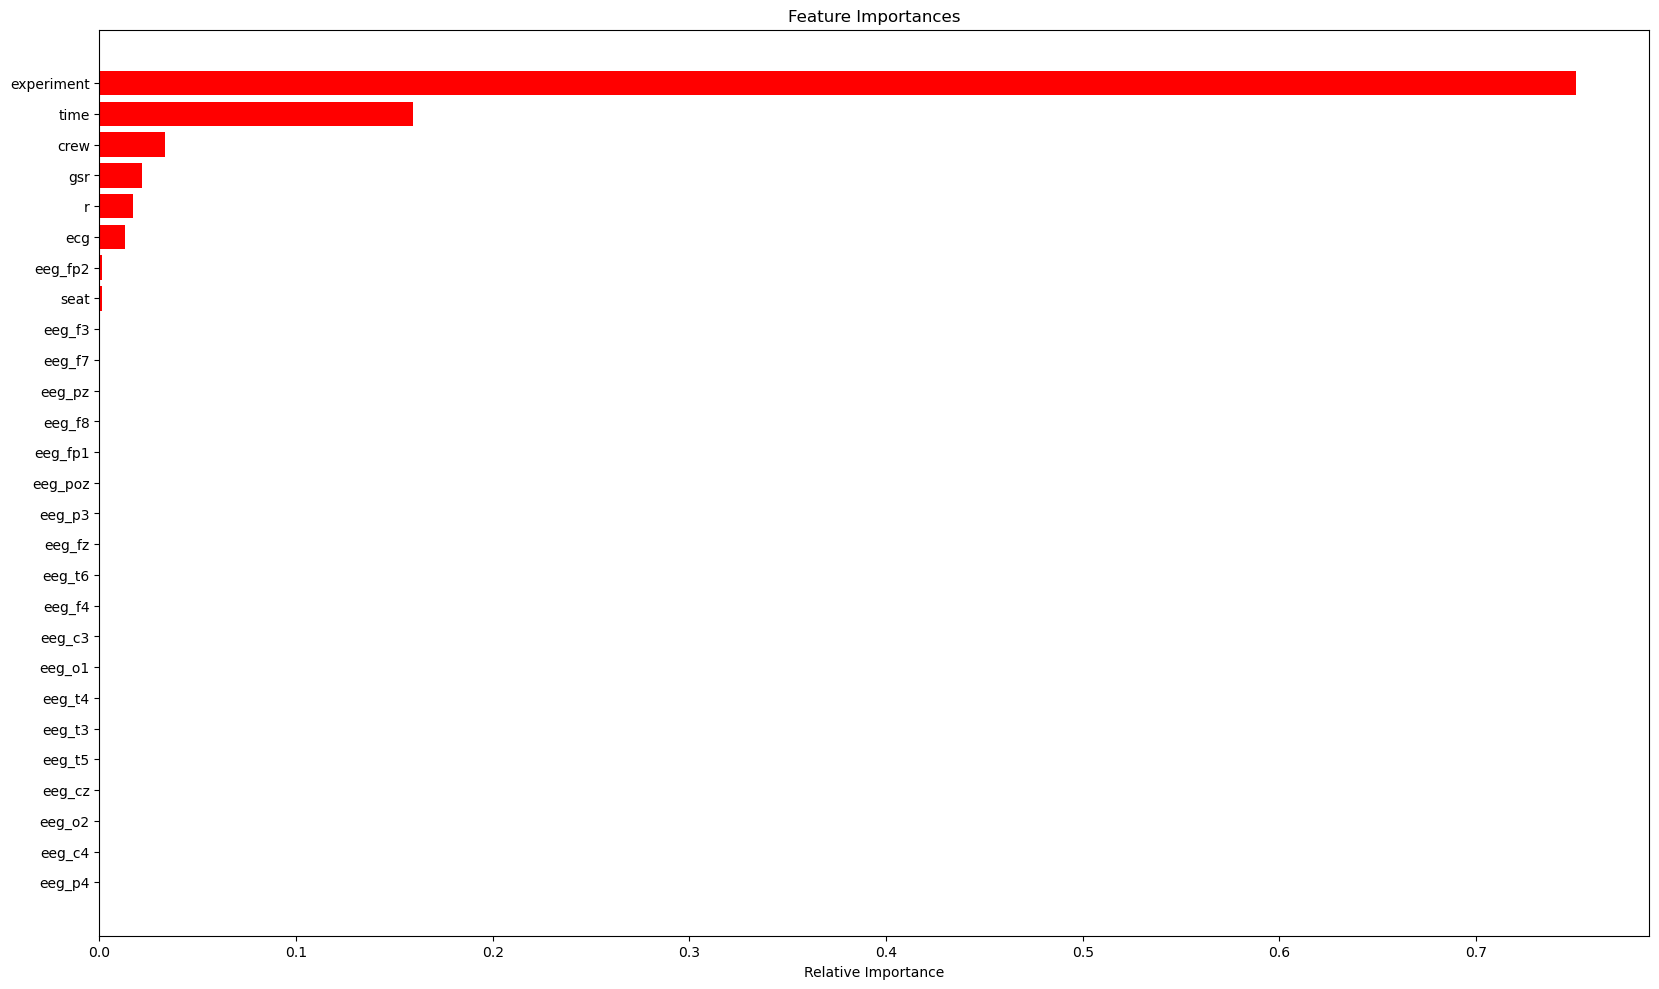

In [72]:
importances = clf.feature_importances_
indices = (np.argsort(importances))[:]
plt.figure(figsize=(20,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**Experiment has the max feature importance, others are not even close to it, its logical as when experiment 'CA' then chance there are only 2 options 'CA' or baseline, same goes with other events too, So, using experiment as a feture 
model predictions become independent of other important features!** 
*Kind of EXP performed is highly mapped with target class*

In [73]:
y_train_pred = clf.predict_proba(X_train)
y_test_pred = clf.predict_proba(X_test)

In [76]:
print(f"Train log_loss:{log_loss(y_train, y_train_pred)}")
print(f"Test log_loss:{log_loss(y_test, y_test_pred)}")

Train log_loss:3.2089114168881236e-15
Test log_loss:0.010182621021733746


#### Lets take only device readings as a feaures as they are true the traits for determining the state of the pilots

In [82]:
X_ = X.drop(['time', 'crew', 'experiment', 'seat'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_,Y, stratify=Y, test_size=.2)
print(f"X_train.shape:{X_train.shape}")
print(f"y_train.shape:{y_train.shape}")
print(f"X_test.shape:{X_test.shape}")
print(f"y_test.shape:{y_test.shape}")

X_train.shape:(3893936, 23)
y_train.shape:(3893936,)
X_test.shape:(973485, 23)
y_test.shape:(973485,)


In [83]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

#### Feature importance

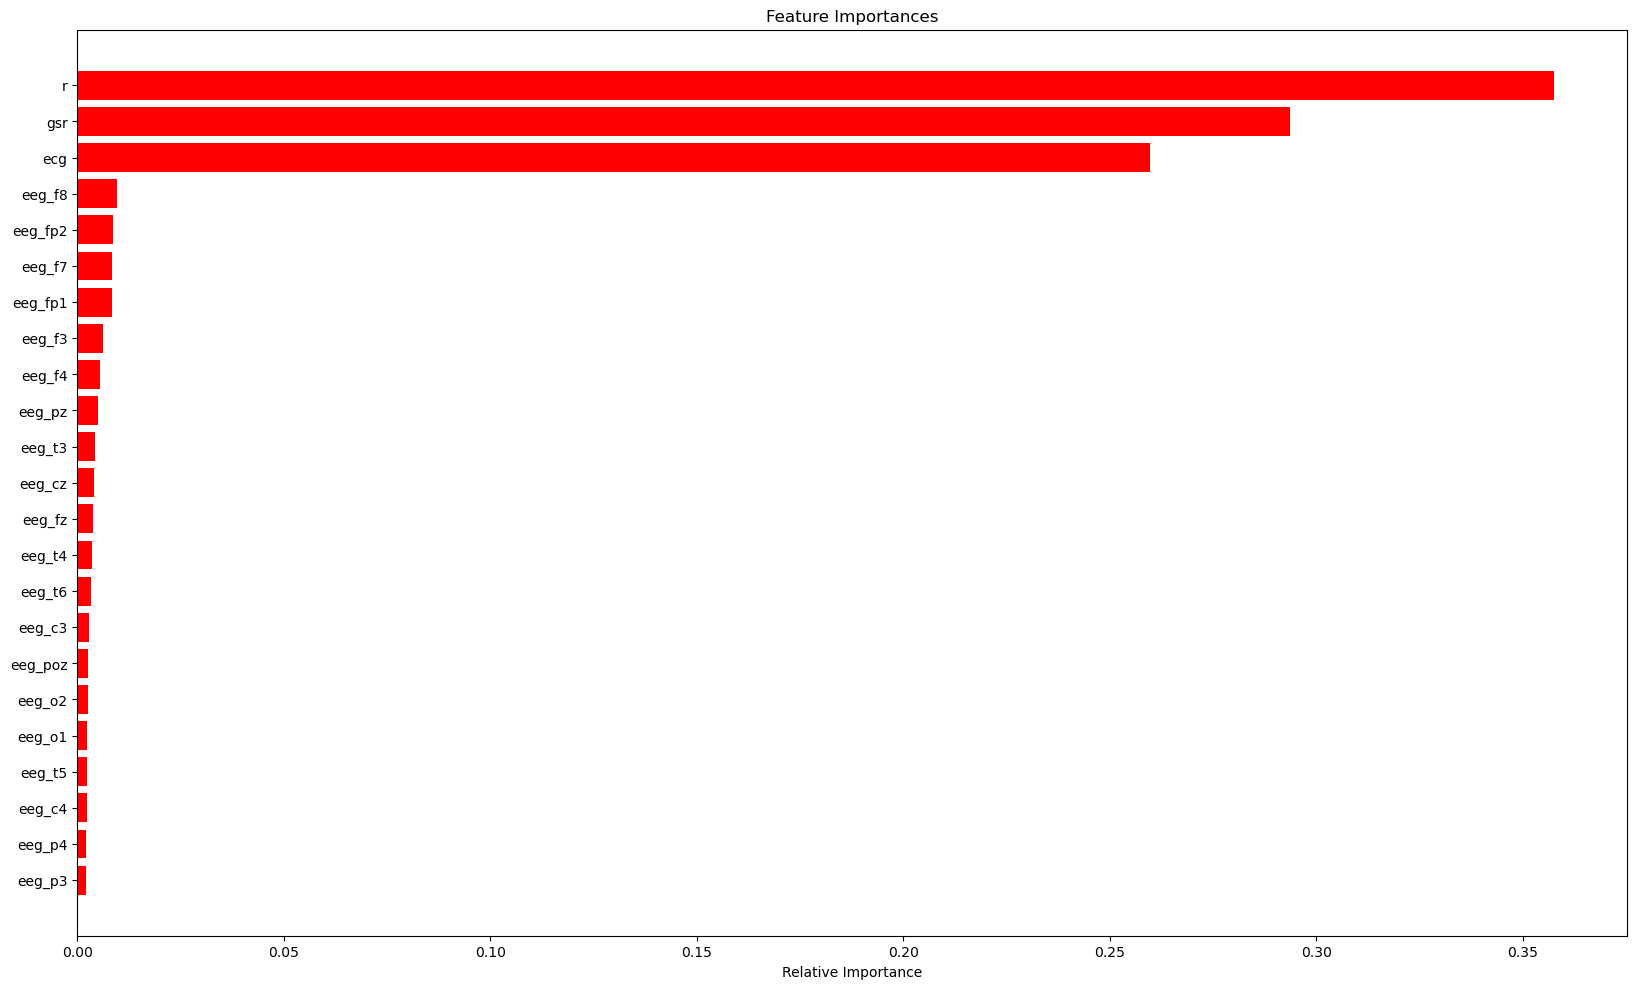

In [85]:
features = X_.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[:]
plt.figure(figsize=(20,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

* r, gsr, ecg are more important than Brain impulse data (EEG)
* Respiration information helping more in predicting target variable

In [86]:
y_train_pred = clf.predict_proba(X_train)
y_test_pred = clf.predict_proba(X_test)
print(f"Train log_loss:{log_loss(y_train, y_train_pred)}")
print(f"Test log_loss:{log_loss(y_test, y_test_pred)}")

Train log_loss:3.2089114168881236e-15
Test log_loss:0.5501808508152486


#### If we want to compare the things happening at one part of the brain to the other part then taking the potential difference between two electrodes at those two locations of the scalp might be a helpful feature.

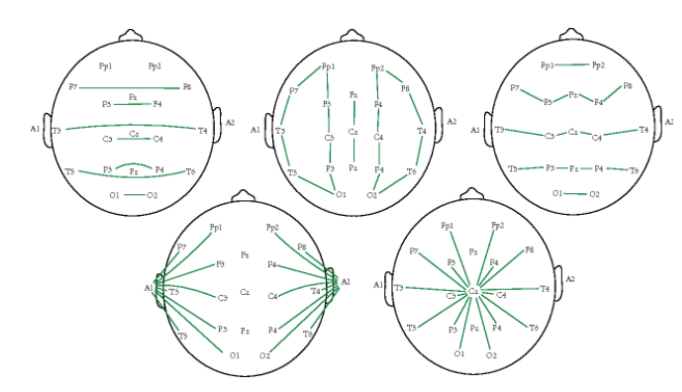

In [98]:
from IPython.display import Image
Image(filename='pd.png')


*there are various permutations for taking potential differences, fig 2 is the most used clinically!*

### We can create feature as electrode potential difference between EEG reading

In [89]:
def get_new_features(df):
    df['fp1_f7'] = df['eeg_fp1'] - df['eeg_f7']
    df['f7_t3'] = df['eeg_f7'] - df['eeg_t3']
    df['t3_t5'] = df['eeg_t3'] - df['eeg_t5']
    df['t5_o1'] = df['eeg_t5'] - df['eeg_o1']
    df['fp1_f3'] = df['eeg_fp1'] - df['eeg_f7']
    df['f3_c3'] = df['eeg_f3'] - df['eeg_c3']
    df['c3_p3'] = df['eeg_c3'] - df['eeg_p3']
    df['p3_o1'] = df['eeg_p3'] - df['eeg_o1']

    df['fz_cz'] = df['eeg_fz'] - df['eeg_cz']
    df['cz_pz'] = df['eeg_cz'] - df['eeg_pz']
    df['pz_poz'] = df['eeg_pz'] - df['eeg_poz']

    df['fp2_f8'] = df['eeg_fp2'] - df['eeg_f8']
    df['f8_t4'] = df['eeg_f8'] - df['eeg_t4']
    df['t4_t6'] = df['eeg_t4'] - df['eeg_t6']
    df['t6_o2'] = df['eeg_t6'] - df['eeg_o2']
    df['fp2_f4'] = df['eeg_fp2'] - df['eeg_f4']
    df['f4_c4'] = df['eeg_f4'] - df['eeg_c4']
    df['c4_p4'] = df['eeg_c4'] - df['eeg_p4']
    df['p4_o2'] = df['eeg_p4'] - df['eeg_o2']
    
    
    pre_cols = ['eeg_fp1', 'eeg_f7', 'eeg_f8',\
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',\
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',\
       'eeg_c3', 'eeg_cz', 'eeg_o2']
 
    df = df.drop(pre_cols, axis=1)
    return df
    

In [90]:
X_train_fe = get_new_features(X_train)
X_test_fe = get_new_features(X_test)

In [91]:
X_train_fe.head()

,ecg,r,gsr,fp1_f7,f7_t3,t3_t5,t5_o1,fp1_f3,f3_c3,c3_p3,...,cz_pz,pz_poz,fp2_f8,f8_t4,t4_t6,t6_o2,fp2_f4,f4_c4,c4_p4,p4_o2
3601390,7873.399902,728.557007,1374.310059,-9.624520,11.142020,-7.678890,2.045920,-9.624520,5.636510,2.979280,...,-6.513000,1.548300,6.009300,-4.014700,-0.074400,-5.131801,-0.053900,6.051300,-3.216601,-5.992400
301532,-2887.600098,816.070007,503.615997,54.017704,30.884998,8.298501,6.014200,54.017704,14.835402,4.126600,...,-14.180200,-19.274700,74.399799,25.031302,5.343299,10.500801,63.591499,30.407402,17.926701,3.349599
3193929,27549.400391,651.299988,830.955994,-72.604499,8.573701,6.966200,0.705599,-72.604499,10.556300,-6.771500,...,2.797100,5.296699,11.529400,24.519298,8.308300,-2.993000,14.278896,16.500603,4.329199,6.255300
2640769,-1816.250000,652.508972,1516.339966,-6.945000,1.689699,2.926701,7.682610,-6.945000,14.828699,8.692501,...,24.991030,-19.230330,1.698600,-6.505600,9.300870,-13.751820,-5.012550,-7.397860,4.120850,-0.968390
1223987,11781.799805,567.932983,707.375000,17.071301,6.575899,0.411200,4.464760,17.071301,-1.734500,3.001500,...,5.543001,6.828090,8.788700,11.704200,7.443620,-2.119790,-4.286801,24.474901,2.192200,3.436430


#### Check if these are playing any role in prediction!

In [93]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_fe, y_train)

DecisionTreeClassifier(random_state=0)

#### Feature importance

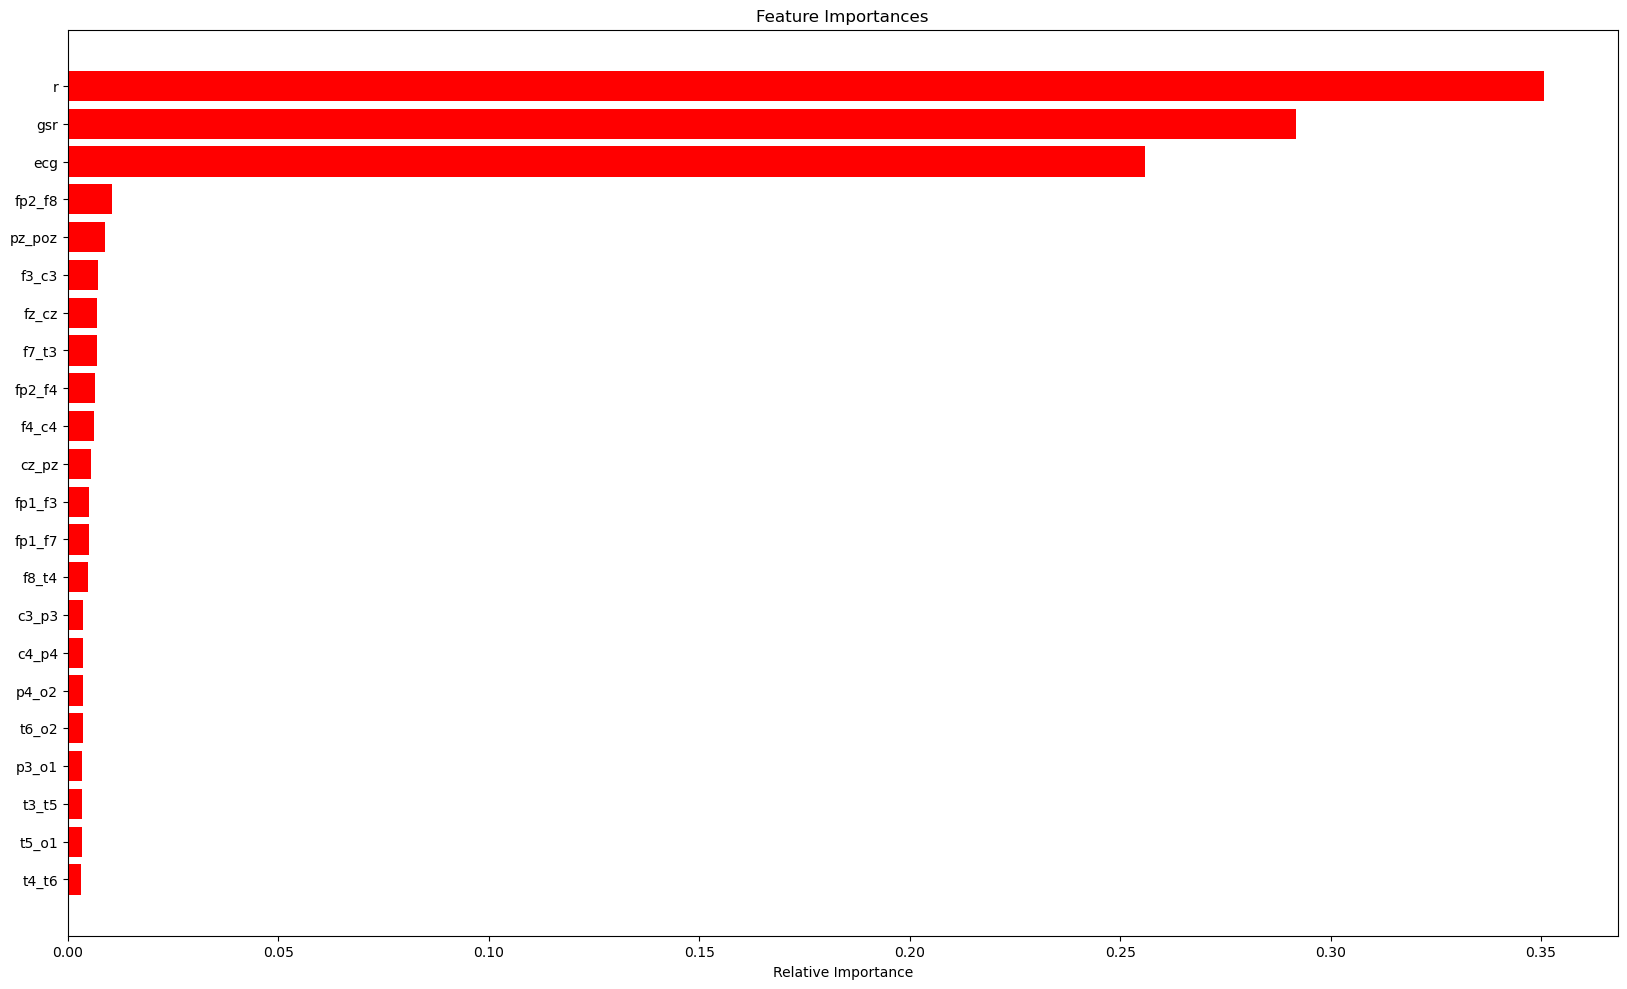

In [94]:
features = X_train_fe.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[:]
plt.figure(figsize=(20,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

*Can be seen new engineered features are not useless!! they have significant impact on Target value*

In [95]:
y_train_pred = clf.predict_proba(X_train_fe)
y_test_pred = clf.predict_proba(X_test_fe)
print(f"Train log_loss:{log_loss(y_train, y_train_pred)}")
print(f"Test log_loss:{log_loss(y_test, y_test_pred)}")

Train log_loss:3.2089114168881236e-15
Test log_loss:0.590733937323395


##### Checking various correlations!

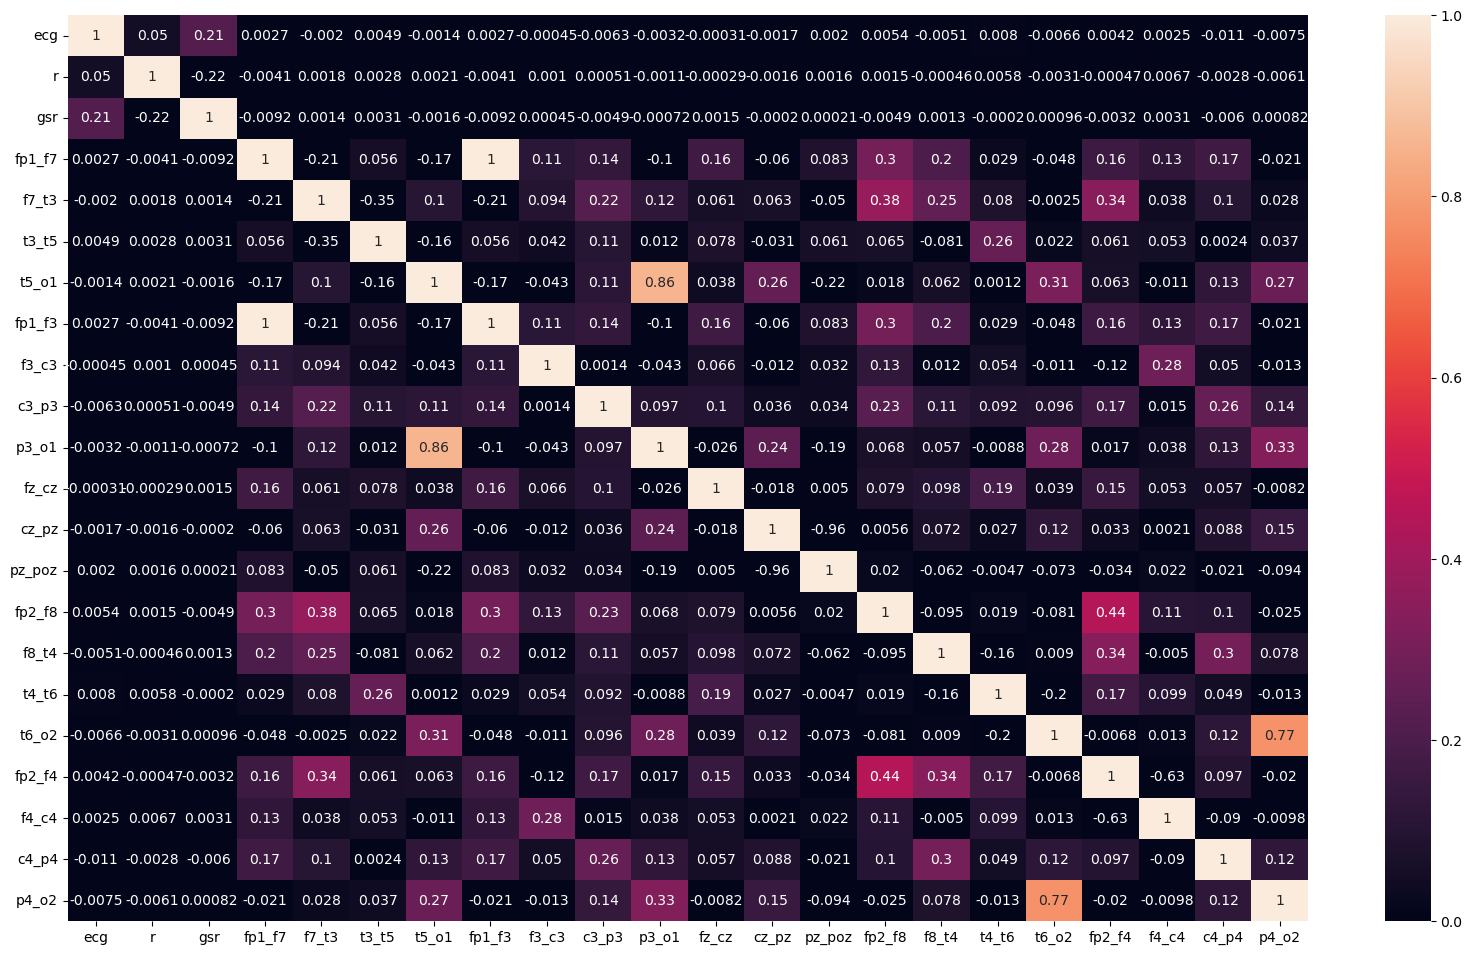

In [96]:
plt.figure(figsize=(20,12))
cor=X_train_fe.corr()
sns.heatmap(cor,annot=True,vmin=0,vmax=1)
plt.show()

*t6_o2 , p4_o2  these two potential difference are higly correlated, actually its logical, 'cause these two t6, p4, o2 are consecutive, there are other combinations too like that!*